In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode, Lambda

from PIL import Image

In [2]:
%load_ext rich
%load_ext autoreload
%autoreload 1

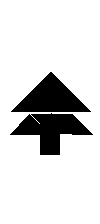

In [3]:
tangram = [[[0.50392557 ,0.50607443],
            [0.32714887 ,0.50607443],
            [0.50392557 ,0.68285113]],
            [[0.50607443, 0.50607443],
            [0.50607443 ,0.68285113],
            [0.68285113 ,0.50607443]],
            [[0.41      , 0.49392557],
            [0.49838835 ,0.40553722],
            [0.32161165 ,0.40553722]],
            [[0.50553722, 0.40753722],
            [0.50553722 ,0.49592557],
            [0.59392557 ,0.40753722]],
            [[0.50446278, 0.49446278],
            [0.50446278 ,0.40607443],
            [0.41607443 ,0.49446278]],
            [[0.45580583, 0.31580583],
            [0.45580583 ,0.40419417],
            [0.54419417 ,0.40419417],
            [0.54419417 ,0.31580583]],
            [[0.6       , 0.49419417],
            [0.51161165 ,0.49419417],
            [0.6        ,0.40580583],
            [0.68838835 ,0.40580583]]]

from cv2 import fillPoly

img = np.full((size := 224, 100), 255, dtype=np.uint8)
fillPoly(img, [[-62, size] + (np.asarray(polygon) * [size, -size]).astype(int) for polygon in tangram], color=0)
image = Image.fromarray(img)
image

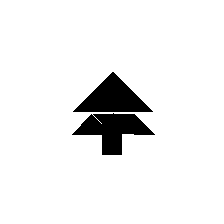

In [4]:
img_s = np.full((size := 224, size), 255, dtype=np.uint8)
fillPoly(img_s, [[0, size] + (np.asarray(polygon) * [size, -size]).astype(int) for polygon in tangram], color=0)
image_s = Image.fromarray(img_s)
image_s

In [5]:
img3 = np.tile(img[:, :, None], (1, 1, 3))

In [6]:
%%timeit
ToTensor()(img3)

81.6 µs ± 6.44 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
Image.fromarray(img)

5.89 µs ± 23.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
%%timeit
np.asarray(image)

6.01 µs ± 19 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### CLIP

In [9]:
import clip
%aimport clip

In [10]:
model, preprocess = clip.load('ViT-L/14')
preprocess


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fed1bbb7040>
    ToTensor()
    Normalize(mean=[0.48145466 0.4578275  0.40821073], std=[0.26862954 0.26130258 0.27577711])
)

In [11]:
tt = ToTensor()
cr = lambda image: image.convert("RGB")
nn = Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
nn255 = Normalize((122.7709383, 116.7460125, 104.09373615000001), (68.5005327, 66.6321579, 70.32316304999999))

In [12]:
%%timeit
preprocess(image)

1.24 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%%timeit
preprocess(image.convert("RGB"))

1.96 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
# Possible inputs to preprocess
# img
# img3

#### Grayscale

###### `broadcast_to` vs `tile` vs `repeat`

In [15]:
%%timeit
img3 = np.broadcast_to(img[:, :, None], img.shape + (3,)).copy()

147 µs ± 834 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
%%timeit
img3 = np.repeat(img[:, :, None], 3, axis=-1)

174 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
%%timeit
img3 = np.tile(img, (1, 1, 3))

6.22 µs ± 87.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


---

In [18]:
%%timeit
np.tile(img, (3, 1, 1)).transpose(1, 2, 0)

6.46 µs ± 380 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [19]:
%%timeit
np.tile(img[:, :, None], (1, 1, 3))  # Tiling in the last dimension is bad

165 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


###### (`as_tensor()` vs `tensor()`) + (`torch(np.tile(...))` vs `torch.tile(torch)`)

In [20]:
%%timeit
torch.as_tensor(np.tile(img, (3, 1, 1)), dtype=torch.float)

29.3 µs ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit
torch.tile(torch.as_tensor(img, dtype=torch.float), (3, 1, 1))

52.9 µs ± 158 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


---

In [22]:
%%timeit
torch.tensor(np.tile(img, (3, 1, 1)), dtype=torch.float)

34.4 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [23]:
%%timeit
torch.tile(torch.tensor(img, dtype=torch.float), (3, 1, 1))

44.6 µs ± 9.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


##### Using `ToTensor()`

In [24]:
%%timeit
Compose([tt, nn])(np.tile((img), (3, 1, 1)).transpose(1, 2, 0))

163 µs ± 3.34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
%%timeit
Compose([tt, nn])(Image.fromarray(img).convert("RGB"))

321 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


##### Using `tensor()`

> Winner (below) - Grayscale

In [26]:
%%timeit
Compose([nn255])(torch.as_tensor(np.tile(img, (3, 1, 1)), dtype=torch.float))

138 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Compiler time: 0.14 s


In [27]:
%%timeit
Compose([lambda x: torch.as_tensor(np.tile(x, (3, 1, 1)), dtype=torch.float), nn255])(img)

136 µs ± 9.55 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Colored

###### (`torch(np.transpose(...))` vs `torch.permute(torch(...))`)

In [28]:
%%timeit
torch.as_tensor(img3.transpose(2, 0, 1), dtype=torch.float32)

22.8 µs ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
%%timeit
torch.as_tensor(img3, dtype=torch.float32).permute(2, 0, 1)

20.3 µs ± 174 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


##### Using `ToTensor()`

> Winner (below) - Colored

In [30]:
%%timeit
Compose([tt, nn])(img3)

166 µs ± 4.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
%%timeit
Compose([tt, nn])(Image.fromarray(img3))

300 µs ± 9.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


##### Using `tensor()`

In [32]:
%%timeit
Compose([nn255])(torch.as_tensor(img3.transpose(2, 0, 1), dtype=torch.float))

186 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
